In [1]:
import sys
sys.path.append("../../smsl")

In [2]:
from smsl.makeDataframe import SpringAgent
from smsl.config import ConfAgent
from smsl.graph import ST_g4dna
from smsl.plotAgent import PlotAgent, palette, SinglePlotAgent
from smsl.plotAgent import font_label, font_xylabel, font_xyticks

In [3]:
import os
import pandas as pd
import numpy as np
from IPython.display import JSON
import json
import matplotlib.pyplot as plt
from copy import deepcopy

In [4]:
class HotSpotAgent(dict, ConfAgent):
    def __init__(self, MAgent):
        ConfAgent.__init__(self)
        self.end_ns = self.time_num
        self.framesperns = self.frame_num // self.time_num
        self.MAgent = MAgent
    def load_systems(self, system2offical_name):
        ori_path = os.getcwd()
        for system, system_offical_name in system2offical_name.items():
            os.chdir(f'../../{system}/d.fluctmatch')
            b_agent = SpringAgent()
            b_agent.system_offical_name = system_offical_name
            self[system] = b_agent
        os.chdir(ori_path)
    def read_dict_hotspot_from_json(self, subgroups, is_return=False):
        dict_hotspot = {}
        for s in subgroups:
            with open(f'./data/{s}.json', 'r') as f:
                data = json.load(f)
                dict_hotspot[s] = {system:d1 for system, d1 in data.items() if system in self.keys()} 
            for system, d1 in dict_hotspot[s].items():
                positions = list(d1.keys())
                for position in positions:
                    position_tuple = tuple(position.split(','))
                    if len(position_tuple)==1:
                        position_tuple = position_tuple[0]
                    d1[position_tuple] = d1.pop(position)
            ## for dsdna
            if 'dsdna' in self:
                with open(f'./data/dsdna.json', 'r') as f:
                    data = json.load(f)
                    dict_hotspot[s]['dsdna'] = data[s]['dsdna']
        if is_return:
            return dict_hotspot
        else:
            self.dict_hotspot = dict_hotspot

In [42]:
system2offical_name = {
'propeller': 'Propeller',
'basket'   : 'Basket',
'chair'    : 'Chair',
'hybrid-i' : 'Hybrid-I',
'hybrid-ii': 'Hybrid-II',
# 'dsdna'    : 'dsDNA',
# 'basket_na': 'Basket-Na',
# 'hybrid-ii_wttel26'    : 'Hybrid-II-wtTel26',
# 'propeller_poh'        : 'Propeller-POH',
# 'propeller_ewv'        : 'Propeller-EWV', 
# 'hybrid-ii_wttel26_ewv': 'Hybrid-II-wtTel26-EWV', 
# 'hybrid-ii_wttel26_poh': 'Hybrid-II-wtTel26-POH', 
}

subgroups = ['st']

In [43]:
hs_agent = HotSpotAgent(ST_g4dna)
hs_agent.load_systems(system2offical_name)
hs_agent.read_dict_hotspot_from_json(subgroups)

In [44]:
JSON(hs_agent.dict_hotspot)

<IPython.core.display.JSON object>

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
keys must be str, int, float, bool or None, not tuple
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [45]:
def get_layer_and_gstrand_by_resid(self, resid):
    df_gstrand_level_resid = self.df_tetrad_geometry.stack().reset_index()
    row_col = df_gstrand_level_resid[df_gstrand_level_resid[0] == resid][['level_0', 'level_1']].iloc[0]
    return row_col['level_0'], row_col['level_1']

In [88]:
dict_d3['query']

'C2C4'

In [89]:
st_step2hotspot2gstrand_direction2ks = {
    'anti-anti': {},
    'syn-anti' : {},
    'anti-syn' : {},
}
gstrand_direction2ks = {'otimes':[], 'odot':[]}
for system, dict_d1 in hs_agent.dict_hotspot[subgroups[0]].items():
    for position, dict_d2 in dict_d1.items():
        gstrand, layer = position
        ## stack step
        layer_i, layer_j = [layer, 'mid'] if layer=='top' else ['mid', layer]
        resid_i_q3 = hs_agent[system].df_tetrad_geometry.loc[layer_i, 'Q3']
        resid_j_q3 = hs_agent[system].df_tetrad_geometry.loc[layer_j, 'Q3']
        GBA_i_q3 = hs_agent[system].GBAc[resid_i_q3]
        GBA_j_q3 = hs_agent[system].GBAc[resid_j_q3]
        st_step = f'{GBA_i_q3}-{GBA_j_q3}'
        resids_in_gstrand = hs_agent[system].df_tetrad_geometry[gstrand].to_list()
        gstrand_direction = 'otimes' if resids_in_gstrand == sorted(resids_in_gstrand) else 'odot'
        print(system, position, st_step, gstrand_direction)
        for hotspot_id, dict_d3 in dict_d2['hotspot'].items():
            if hotspot_id == 'avg':
                continue
            else:
                hotspot = dict_d3['query']
                k = dict_d3['k']['avg']
                # key = (system, position, dict_d3['query'])
                st_step2hotspot2gstrand_direction2ks[st_step].setdefault(hotspot, deepcopy(gstrand_direction2ks))
                st_step2hotspot2gstrand_direction2ks[st_step][hotspot][gstrand_direction].append(k)

propeller ('Q3', 'top') anti-anti otimes
propeller ('Q2', 'top') anti-anti otimes
propeller ('Q1', 'top') anti-anti otimes
propeller ('Q4', 'top') anti-anti otimes
propeller ('Q3', 'bot') anti-anti otimes
propeller ('Q2', 'bot') anti-anti otimes
propeller ('Q1', 'bot') anti-anti otimes
propeller ('Q4', 'bot') anti-anti otimes
basket ('Q3', 'top') anti-syn otimes
basket ('Q2', 'top') anti-syn odot
basket ('Q1', 'top') anti-syn odot
basket ('Q4', 'top') anti-syn otimes
basket ('Q3', 'bot') syn-anti otimes
basket ('Q2', 'bot') syn-anti odot
basket ('Q1', 'bot') syn-anti odot
basket ('Q4', 'bot') syn-anti otimes
chair ('Q3', 'top') syn-anti otimes
chair ('Q2', 'top') syn-anti odot
chair ('Q1', 'top') syn-anti otimes
chair ('Q4', 'top') syn-anti odot
chair ('Q3', 'bot') anti-anti otimes
chair ('Q2', 'bot') anti-anti odot
chair ('Q1', 'bot') anti-anti otimes
chair ('Q4', 'bot') anti-anti odot
hybrid-i ('Q3', 'top') syn-anti otimes
hybrid-i ('Q2', 'top') syn-anti otimes
hybrid-i ('Q1', 'top')

In [91]:
JSON(st_step2hotspot2gstrand_direction2ks)

<IPython.core.display.JSON object>

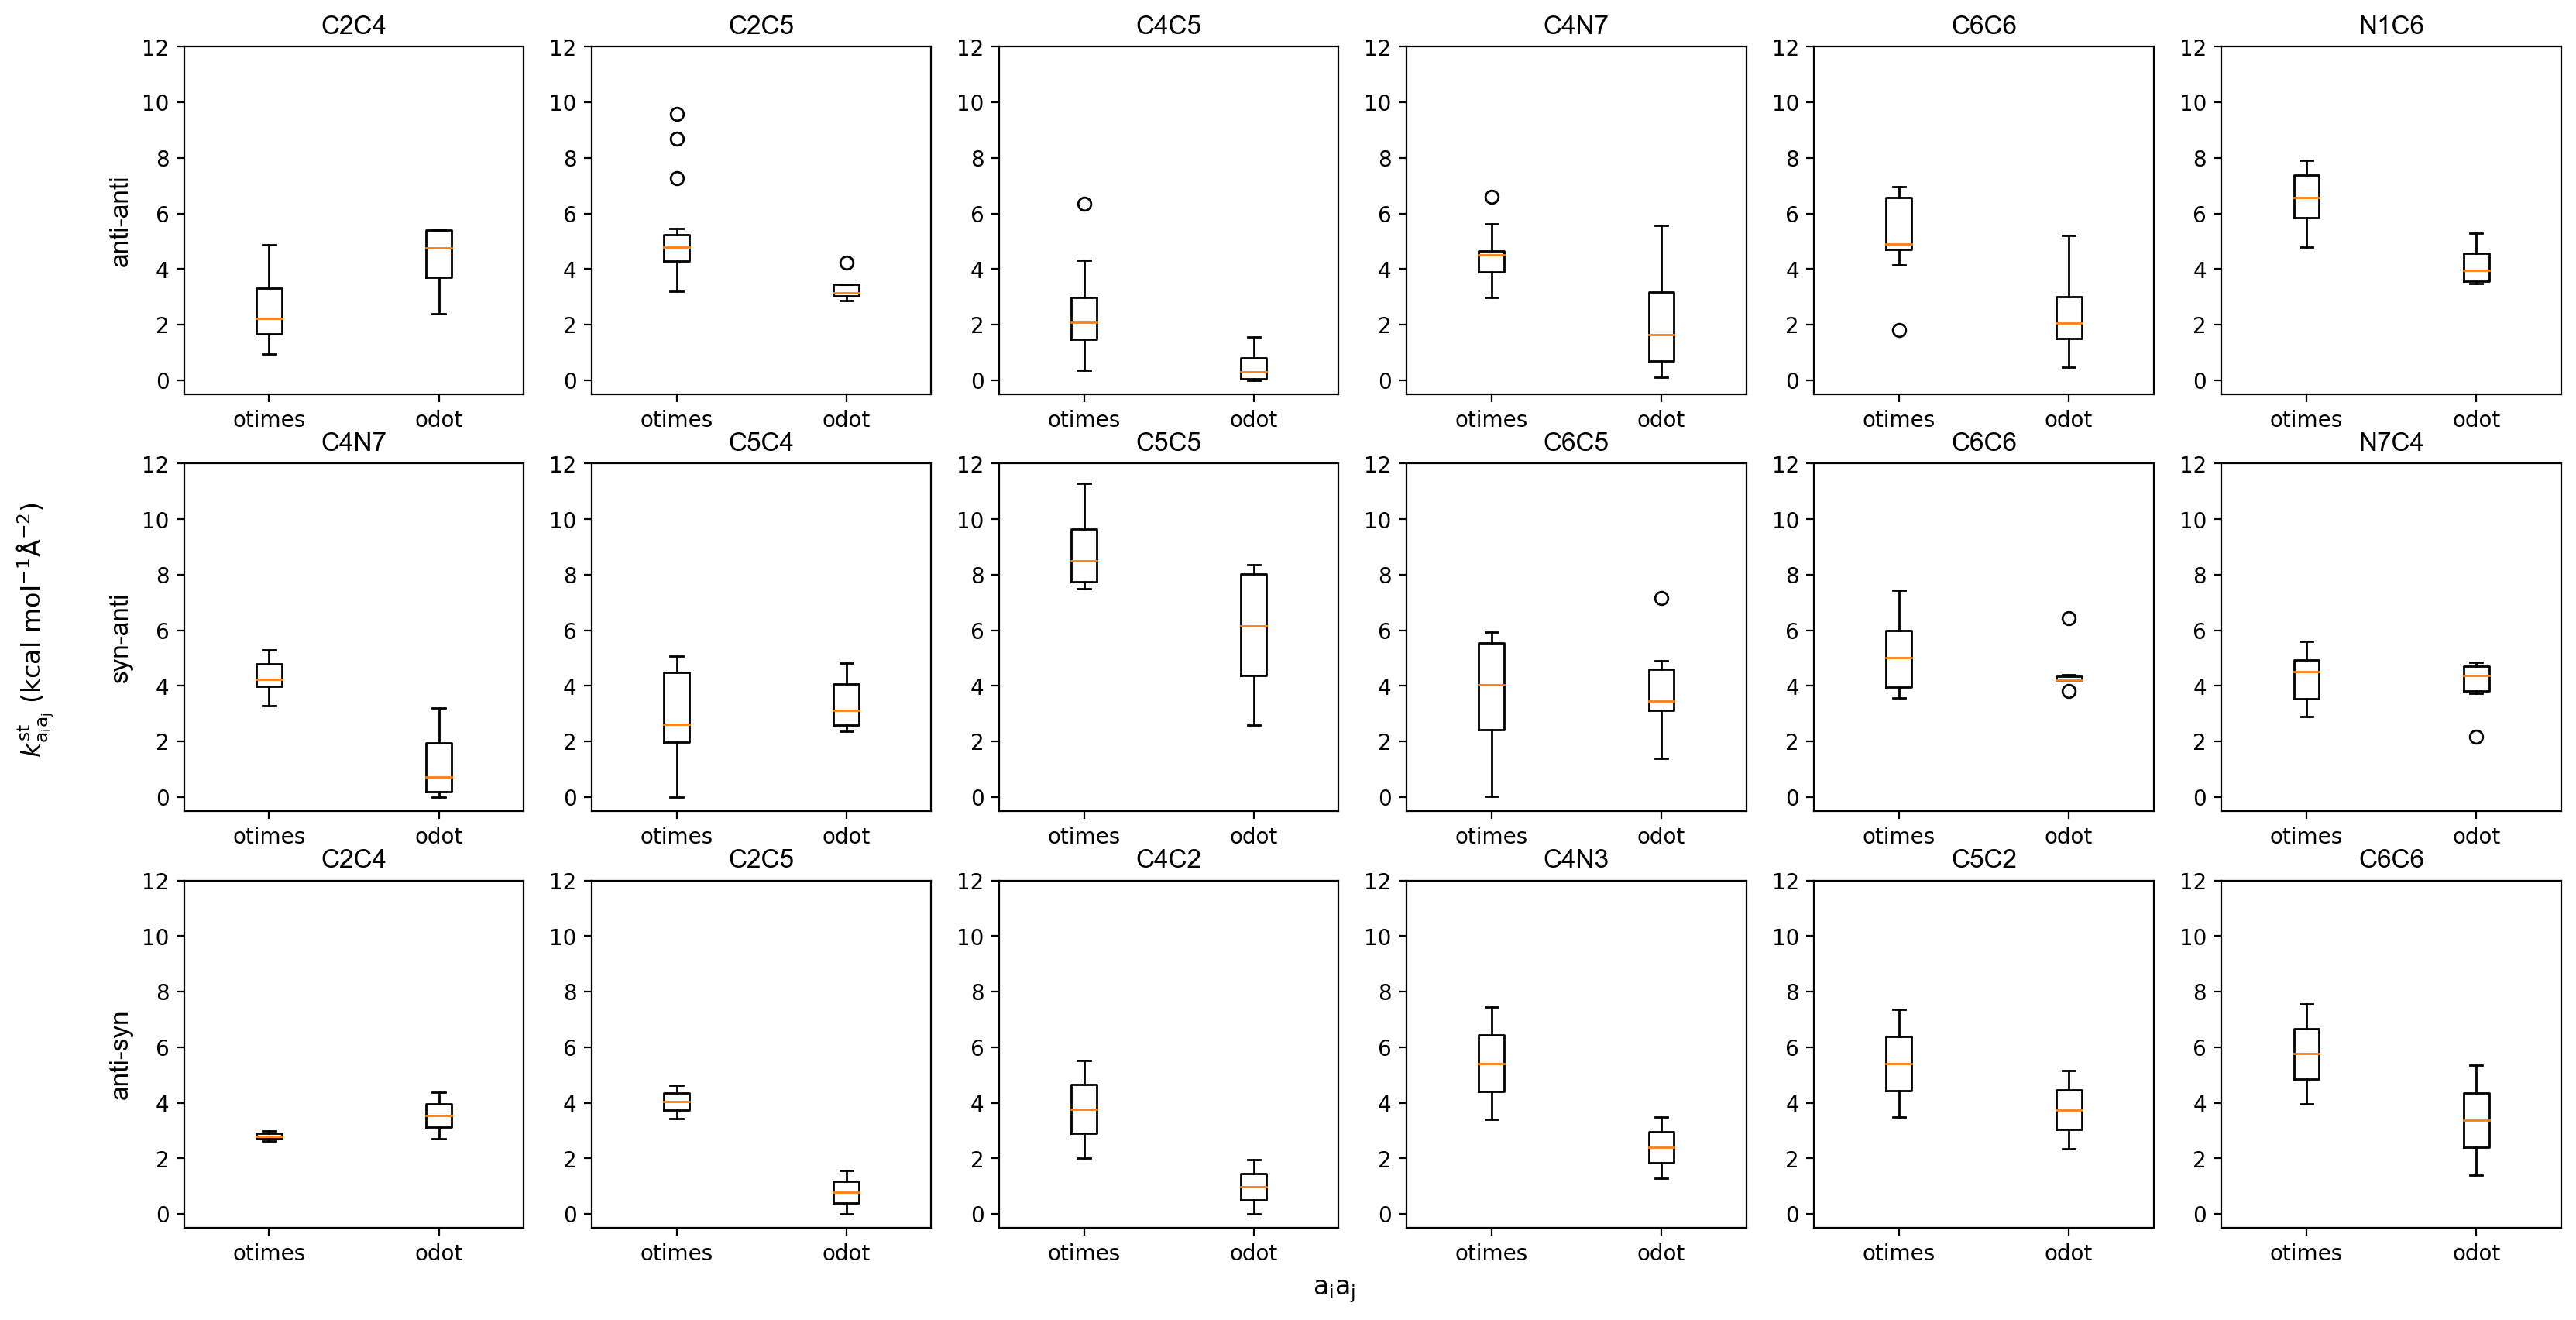

In [113]:
p_agent = PlotAgent(nrows=3, ncols=6, figsize_1=[3.3, 3.3], hspace=0.2, wspace=0.2, sharex=False, sharey=False)
for i, (st_step, hotspot2gstrand_direction2ks) in enumerate(st_step2hotspot2gstrand_direction2ks.items()):
    p_agent.axs[i,0].set_ylabel(st_step, fontdict=font_xylabel)
    for j, (hotspot, gstrand_direction2ks) in enumerate(hotspot2gstrand_direction2ks.items()):
        p_agent.axs[i,j].set_title(hotspot, fontdict=font_xylabel)
        p_agent.axs[i,j].boxplot(gstrand_direction2ks.values(), labels=gstrand_direction2ks.keys())
        p_agent.axs[i,j].set_ylim(-0.5, 12)
p_agent.fig.supxlabel(r'$\rm{a}_{i}\rm{a}_j$', y=0.06)
p_agent.fig.supylabel(r'$k^{\rm{st}}_{\rm{a}_{i}\rm{a}_j}$ (kcal mol$^{-1} {\rm{\AA}^{-2}}$)', x=0.07)
plt.show()
# p_agent.savefig('kst_by_aiaj.svg')